## Семинар 8: "Снижение размерности"

ФИО: Валинуров Денис Юрьевич

In [1]:
import numpy as np
from sklearn.datasets import fetch_olivetti_faces
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch import optim
from torch.autograd import Variable
%matplotlib inline

Этот семинар посвящен снижению размерности на примере данных Olivetti faces. В данных содержатся 400 черно-белых изображений 64x64. Требуется исследовать различные способы снижения размерности: PCA и Автокодировщик

In [2]:
X = fetch_olivetti_faces()['data']

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /home/denis/scikit_learn_data


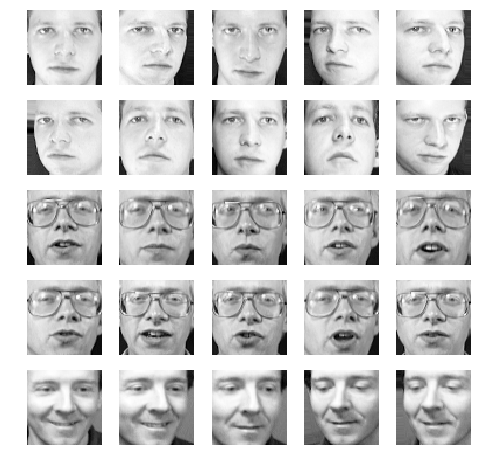

In [3]:
plt.figure(figsize=(8, 8))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(64, 64), cmap=plt.cm.Greys_r)
    plt.axis('off')
plt.show()

### Часть 1: PCA

In [4]:
from sklearn.decomposition import PCA

<i> 1.1 Примените алгоритм PCA к данным и отобразите главные компоненты. В качестве числа компонент выберите 25</i>

Подсказка: используйте метод <b>.components_</b>

In [5]:
X.shape

(400, 4096)

In [6]:
model = PCA(n_components=25)
model.fit(X)

PCA(copy=True, iterated_power='auto', n_components=25, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [7]:
principle_components = model.components_

In [8]:
principle_components.shape

(25, 4096)

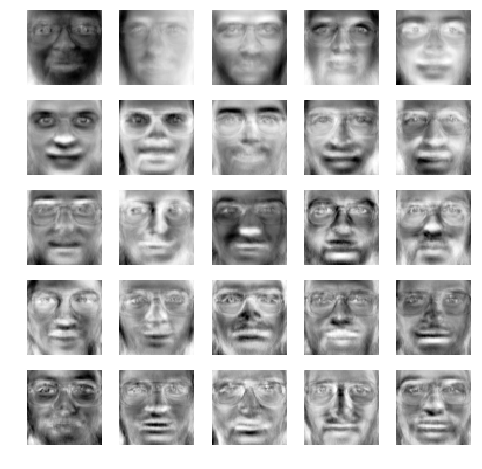

In [9]:
plt.figure(figsize=(8, 8))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(principle_components[i].reshape(64, 64), cmap=plt.cm.Greys_r)
    plt.axis('off')
plt.show()

<i> 1.2 Отобразите зависимость качества восстановления от количества компонент</i>

Подсказка: используйте метод <b>.explained\_variance\_ratio\_</b>

In [10]:
model = PCA()
model.fit(X)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

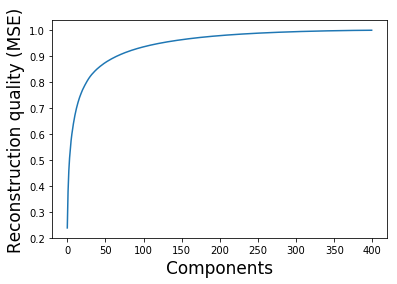

In [11]:
plt.plot(np.cumsum(model.explained_variance_ratio_))
plt.xlabel('Components', fontsize=17)
plt.ylabel('Reconstruction quality (MSE)', fontsize=17)

In [14]:
model = PCA(n_components=50)
model.fit(X)
embedding = model.transform(X)
reconstruction = model.inverse_transform(embedding)

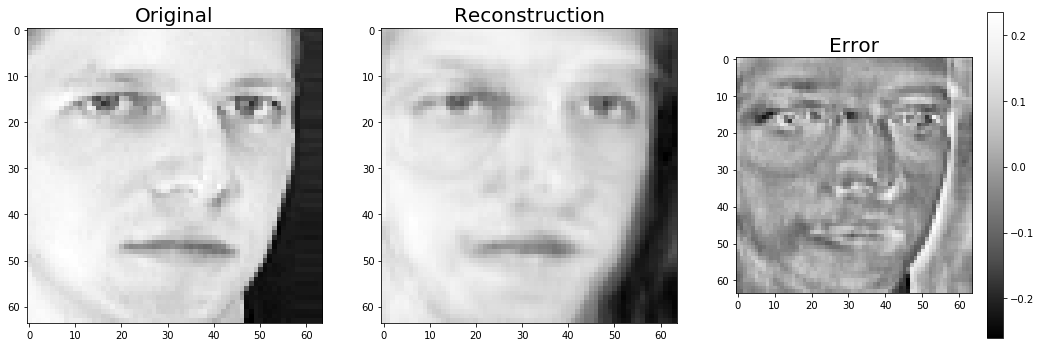

In [15]:
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.imshow((X)[1].reshape(64, 64), cmap=plt.cm.Greys_r)
plt.title('Original', fontsize=20)
plt.subplot(1, 3, 2)
plt.imshow((reconstruction)[1].reshape(64, 64), cmap=plt.cm.Greys_r)
plt.title('Reconstruction', fontsize=20)
plt.subplot(1, 3, 3)
plt.imshow((reconstruction - X)[1].reshape(64, 64), cmap=plt.cm.Greys_r)
plt.colorbar()
plt.title('Error', fontsize=20)

<i>1.3 Какое количество компонент следует выбирать, чтобы соблюсти баланс размерность — качество?</i>

Кажется, что перегиб графика идёт примерно при 50 компонентах.

<i>1.4 Отобразите данные на плоскости (количество компонент = 2). Выделились ли какие-нибудь кластеры? Если да, чему они соответствуют?</i>

In [16]:
model = PCA(n_components=2)
model.fit(X)
embedding = model.transform(X)
reconstruction = model.inverse_transform(embedding)

In [17]:
def plot_dataset(X, emb, margin=50, frame=2000., imsize=64):
    assert(emb.shape[1] == 2)
    emb = np.array((emb - emb.min(0)) * (frame / (emb.max(0) - emb.min(0))) + margin, dtype = np.int)
    image = np.zeros((int(emb[:, 0].max() + margin + imsize), int(emb[:, 1].max() + margin + imsize))) + 1
    for k in range(X.shape[0]):
        image[emb[k, 0]:emb[k, 0]+64, emb[k, 1]:emb[k, 1]+64] = X[k].reshape(64, 64)
    plt.figure(figsize=(20, 20))
    plt.imshow(image, cmap="Greys_r")
    plt.axis("off")
    plt.show()

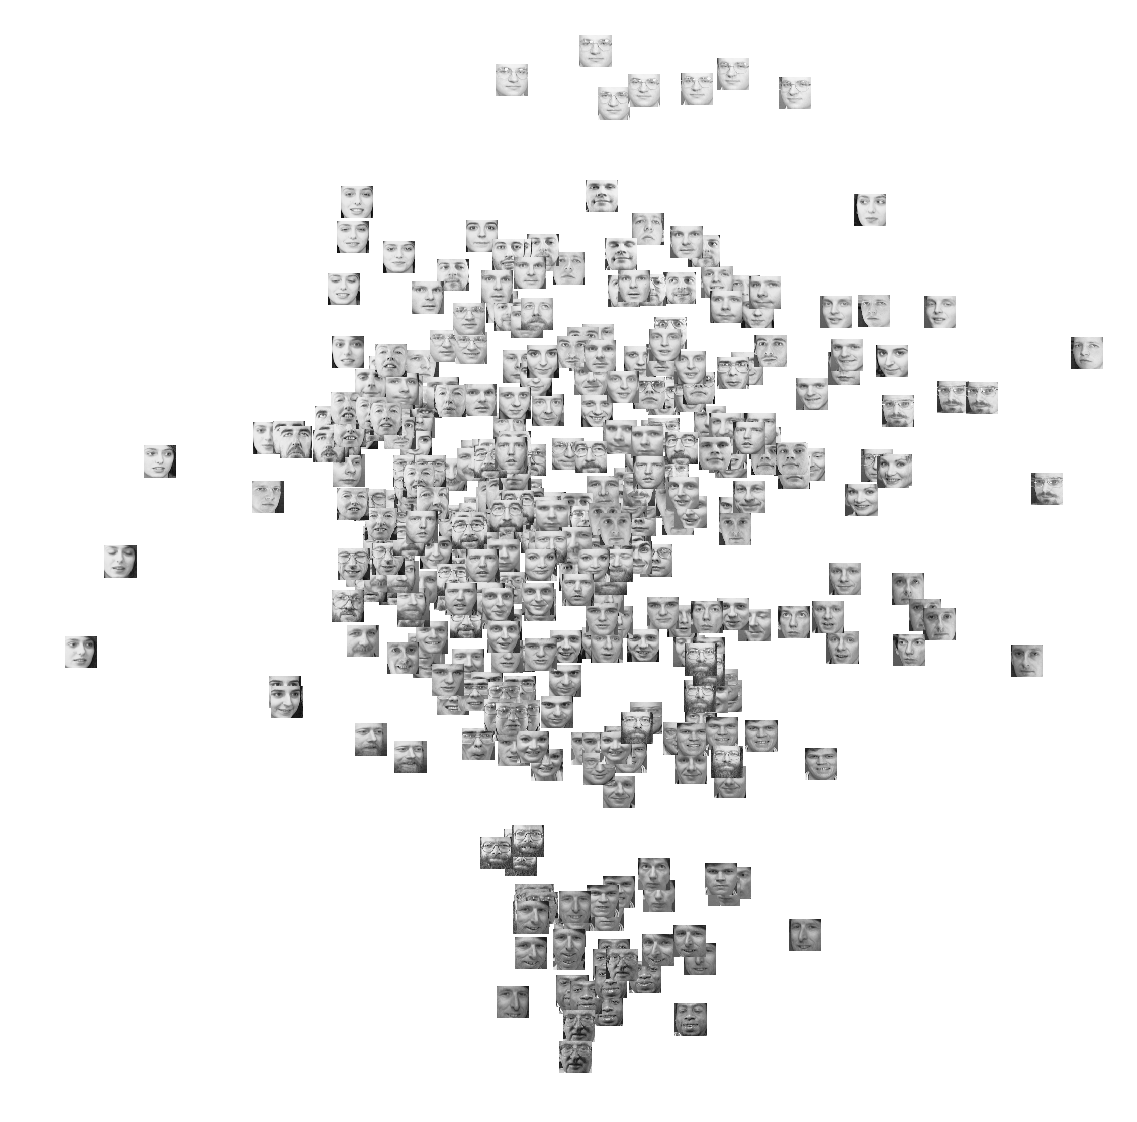

In [18]:
plot_dataset(X, embedding)

Первая компонента — освещение, вторая — в какую сторону смотрит человек

###  Часть 2: Автокодировщик

<i> 2.1 Обучите автокодировщик с архитектурой 4096 -> 200 -> 10 -> 200 -> 4096. В качестве нелинейностей используйте сигмоиду.</i>

In [19]:
from torch.utils.data import DataLoader, Dataset

In [20]:
dataloader = DataLoader(X, batch_size=400, shuffle=True)

In [21]:
def fully_connected(arc, last_nonlinearity=True):
    layers = []
    for i in range(len(arc)-1):
        layers.append(nn.Linear(arc[i], arc[i+1]))
        if i != len(arc)-2 or last_nonlinearity:
            layers.append(nn.Sigmoid())
    return nn.Sequential(*layers)

In [22]:
fully_connected([4096, 200, 10], last_nonlinearity=False)

Sequential(
  (0): Linear(in_features=4096, out_features=200, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=200, out_features=10, bias=True)
)

In [23]:
class AE(nn.Module):
    def __init__(self, arc_encoder, arc_decoder):
        super(AE, self).__init__()
        # create encoder:
        self.encoder = fully_connected(arc_encoder, last_nonlinearity=False)
        self.decoder = fully_connected(arc_decoder, last_nonlinearity=False)
        
    def forward(self, X):
        return self.decoder(self.encoder(X))

In [63]:
model = AE([4096, 200, 10], [10, 200, 4096])

In [64]:
model

AE(
  (encoder): Sequential(
    (0): Linear(in_features=4096, out_features=200, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=200, out_features=10, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=200, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=200, out_features=4096, bias=True)
  )
)

In [65]:
loss = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [66]:
import sys

In [67]:
for epoch in xrange(200):
    losses = []
    for x in dataloader:
        x_batch = Variable(x)
        y_batch = Variable(x, requires_grad=False)
        model.zero_grad()
        x_reconstruction = model(x_batch)
        loss_batch = loss(x_reconstruction, y_batch)
        loss_batch.backward()
        optimizer.step()
        losses.append(loss_batch.data[0])
    sys.stdout.write('\r {}'.format(np.mean(losses)))

 0.0168836694211

In [44]:
embedding = model.encoder(Variable(torch.Tensor(X))).data.numpy()

In [45]:
reconstruction = model(Variable(torch.Tensor(X))).data.numpy()

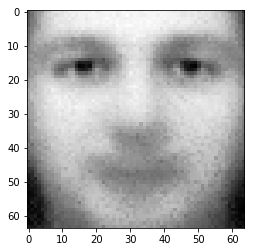

In [46]:
plt.imshow(reconstruction[0].reshape(64, 64), cmap=plt.cm.Greys_r)

<i> 2.2 Какое качество восстановления удалось получить?</i>

<i> 2.3 Обучите сеть с разными размерностями пространства, в которое происходит отображение </i>

In [103]:
def various_dim(dim):
    final_losses = []
    for i, d in enumerate(dim):
        model = AE([4096, 200, int(d)], [int(d), 200, 4096])
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        for epoch in xrange(500):
            epoch_losses = []
            for x in dataloader:
                x_batch = Variable(x)
                y_batch = Variable(x, requires_grad=False)
                model.zero_grad()
                x_reconstruction = model(x_batch)
                loss_batch = loss(x_reconstruction, y_batch)
                loss_batch.backward()
                optimizer.step()
                epoch_losses.append(loss_batch.data[0])
        final_losses.append(np.mean(epoch_losses))
        sys.stdout.write('\r {}/{}'.format(i+1, len(dim)))
    return final_losses

In [104]:
dim = np.linspace(2, 200, 20)
losses = various_dim(dim)

 20/20

In [105]:
losses

[0.012365474365651608,
 0.011376716196537018,
 0.012715496122837067,
 0.012746147811412811,
 0.014039111323654652,
 0.012559693306684494,
 0.013378053903579712,
 0.013712311163544655,
 0.013276963494718075,
 0.012654968537390232,
 0.01466057077050209,
 0.013689923100173473,
 0.01232294924557209,
 0.01293269731104374,
 0.013702587224543095,
 0.013580746948719025,
 0.014368274249136448,
 0.014114699326455593,
 0.012225737795233727,
 0.013030038215219975]

<i> 2.4 Сравните графики из пунктов 1.2 и 2.3 </i>

In [106]:
model = PCA()
model.fit(X)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

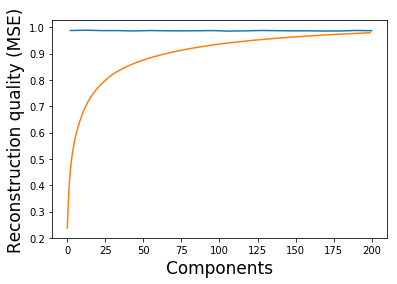

In [107]:
plt.plot(dim, 1-np.array(losses), label='AutoEncoder')
plt.plot(np.cumsum(model.explained_variance_ratio_)[:200], label='PCA')
plt.xlabel('Components', fontsize=17)
plt.ylabel('Reconstruction quality (MSE)', fontsize=17)

<i> 2.5 Отобразите данные на плоскости (количество компонент = 2). Выделились ли какие-нибудь кластеры? Если да, чему они соответствуют?</i>

In [108]:
model = AE([4096, 200, 2], [2, 200, 4096])
loss = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [109]:
for epoch in xrange(500):
    losses = []
    for x in dataloader:
        x_batch = Variable(x)
        y_batch = Variable(x, requires_grad=False)
        model.zero_grad()
        x_reconstruction = model(x_batch)
        loss_batch = loss(x_reconstruction, y_batch)
        loss_batch.backward()
        optimizer.step()
        losses.append(loss_batch.data[0])
    sys.stdout.write('\r {}'.format(np.mean(losses)))

 0.0123309101909

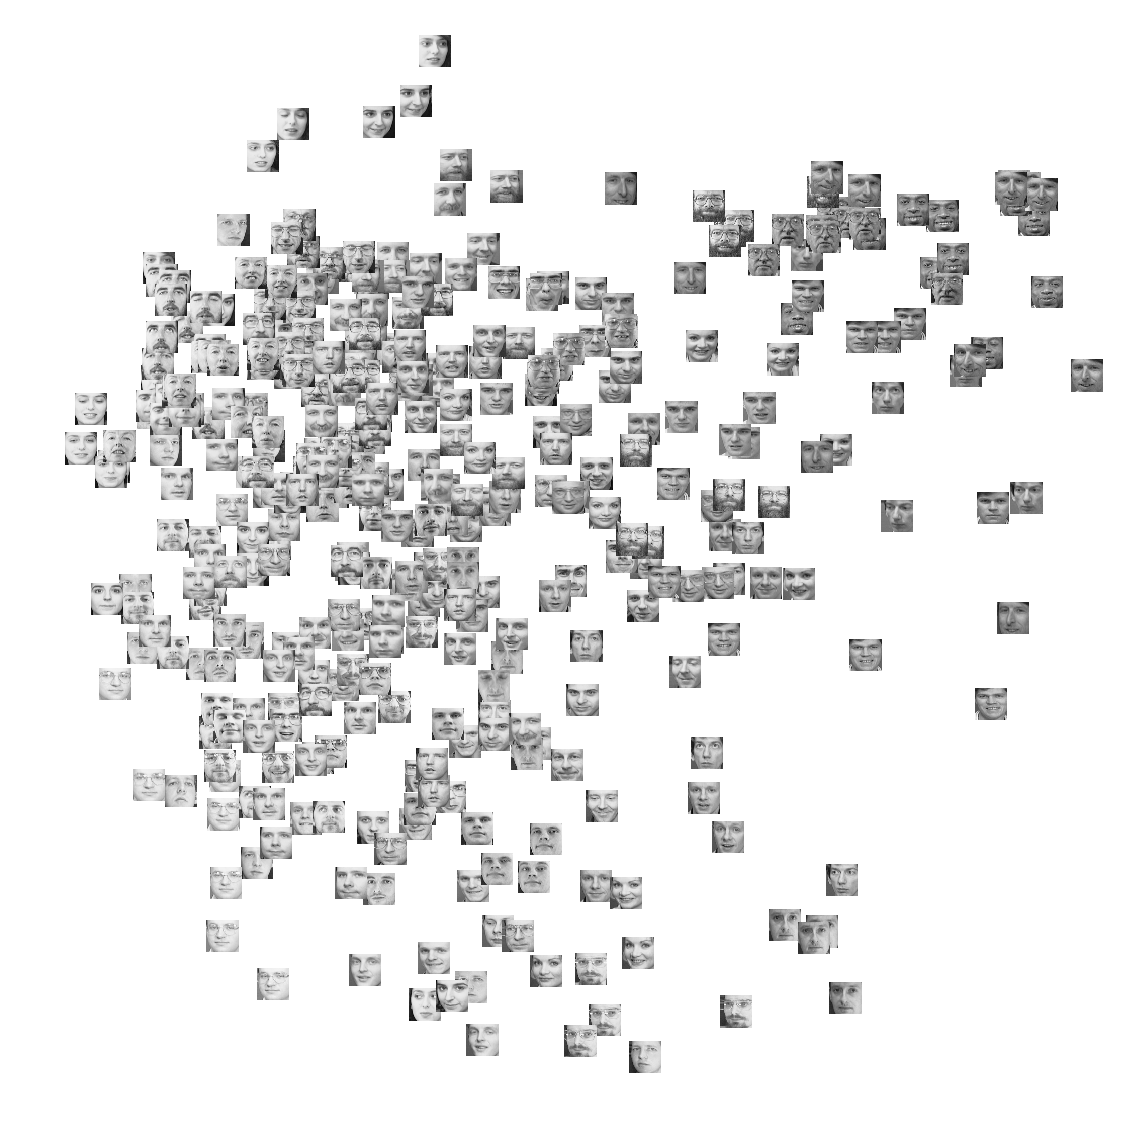

In [110]:
reconstructed = model.encoder(Variable(torch.Tensor(X))).data.numpy()
plot_dataset(X, reconstructed)

Аналогично PCA видно два кластера - освещение и положение лица.

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: